In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sympy.physics.units import pressure

In [2]:
main_path = '/Users/lauritsfauli/PycharmProjects/Final_project_APML'

In [3]:
t2m = xr.open_dataset(main_path + '/era5/' + '/era5_1940_temperature_2m.nc')
geo = xr.open_dataset(main_path + '/era5/' + '/era5_1940_geo500hpa.nc')
mslp = xr.open_dataset(main_path + '/era5/' +'/era5_1940_mean_sea_level_pressure.nc')
t850 = xr.open_dataset(main_path + '/era5/' + '/era5_1940_temperature_850hPa.nc')
prec = xr.open_dataset(main_path + '/era5/' + '/era5_1940_total_precipitation.nc')

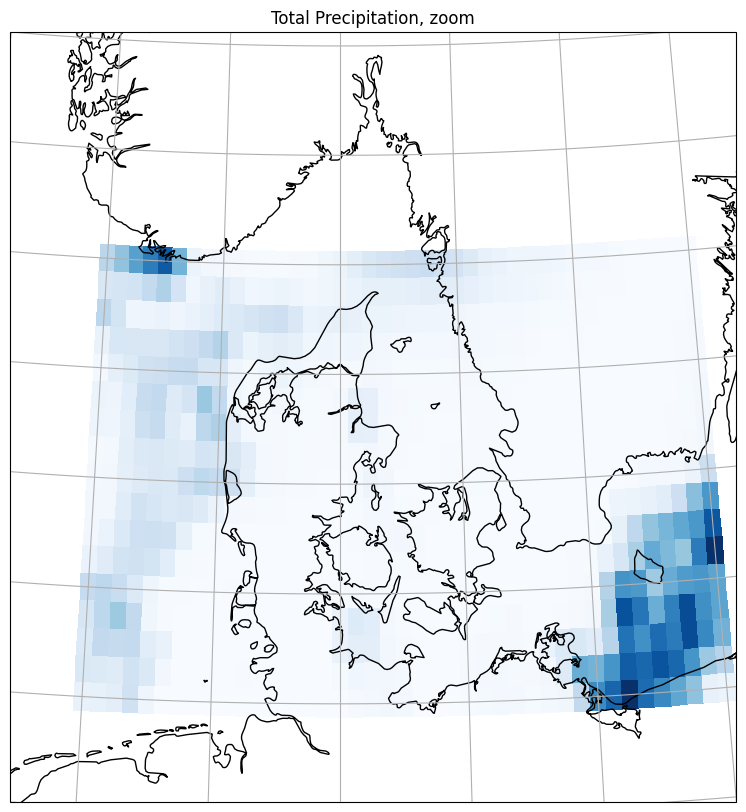

In [4]:
fig, axs = plt.subplots(1, figsize=(15, 10), subplot_kw={'projection': ccrs.Orthographic(10, 54)})

axs.coastlines()
    # ax.add_feature(cfeature.LAND, edgecolor='black')
axs.gridlines()



# Plotting the data
axs.set_title('Total Precipitation, zoom')
axs.set_extent([5, 16, 53, 60], ccrs.PlateCarree())
axs.pcolormesh(prec.longitude, prec.latitude, prec.tp[0], transform=ccrs.PlateCarree(), cmap='Blues', shading='auto')

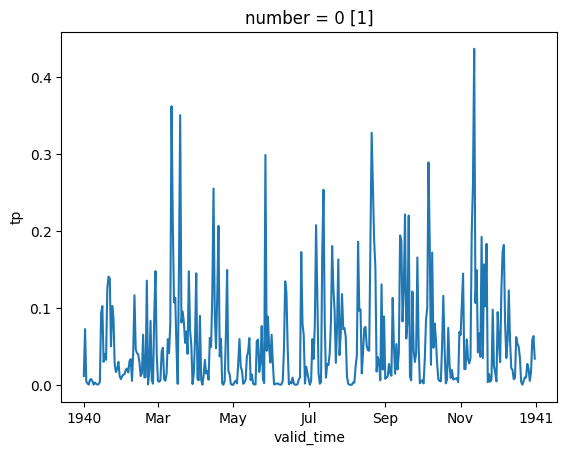

In [5]:

total_prec = prec.tp.sum(dim=['latitude', 'longitude'])
total_prec.plot()

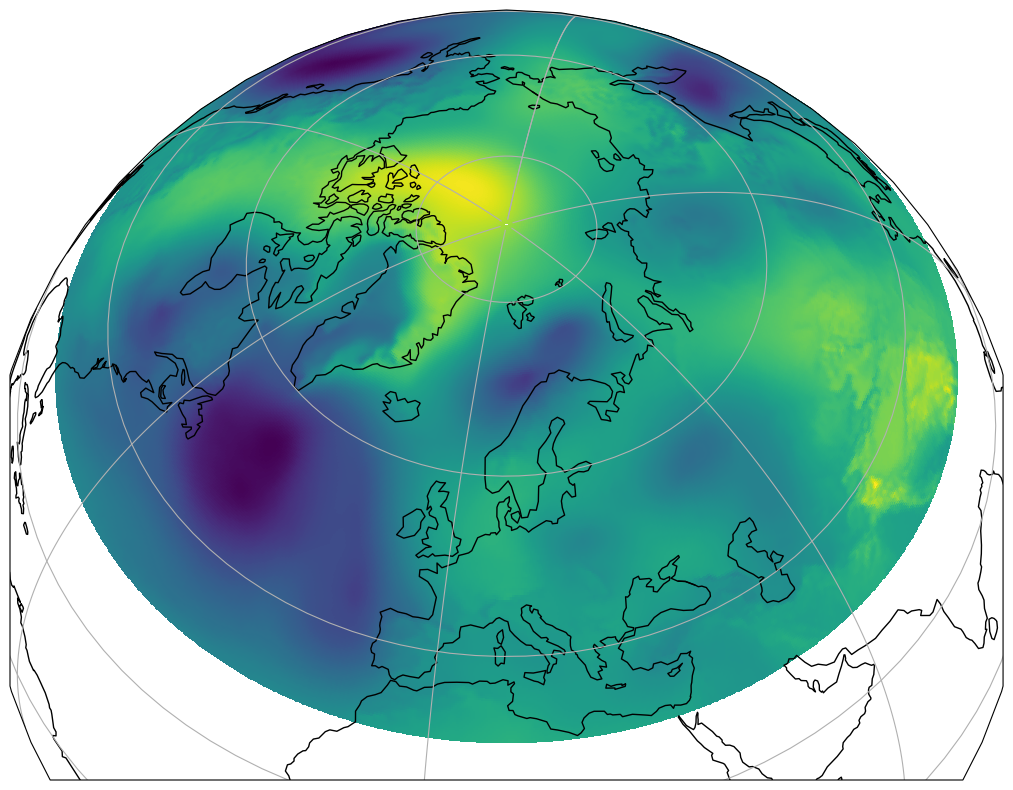

In [6]:
fig, axs = plt.subplots(1, figsize=(15, 10), subplot_kw={'projection': ccrs.Orthographic(10, 54)})

axs.coastlines()
    # ax.add_feature(cfeature.LAND, edgecolor='black')
axs.gridlines()


axs.pcolormesh(mslp.longitude, mslp.latitude, mslp.msl[0], transform=ccrs.PlateCarree(), cmap='viridis', shading='auto')

In [7]:
prec

<xarray.Dataset> Size: 1MB
Dimensions:     (valid_time: 366, latitude: 17, longitude: 41)
Coordinates:
    number      int64 8B ...
  * latitude    (latitude) float64 136B 58.0 57.75 57.5 ... 54.5 54.25 54.0
  * longitude   (longitude) float64 328B 6.0 6.25 6.5 6.75 ... 15.5 15.75 16.0
  * valid_time  (valid_time) datetime64[ns] 3kB 1940-01-01 ... 1940-12-31
Data variables:
    tp          (valid_time, latitude, longitude) float32 1MB 4.832e-05 ... 1...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-16T11:59 GRIB to CDM+CF via cfgrib-0.9.1...

In [8]:
min_lon = -65
max_lon = 35

min_lat = 29
max_lat = 69

t2m_cropped = t2m.sel(
    longitude=slice(min_lon,max_lon),
    latitude=slice(max_lat, min_lat)
)

geo_cropped = geo.sel(
    longitude=slice(min_lon,max_lon),
    latitude=slice(max_lat, min_lat)
)

mslp_cropped = mslp.sel(
    longitude=slice(min_lon,max_lon),
    latitude=slice(max_lat, min_lat)
)

t850_cropped = t850.sel(
    longitude=slice(min_lon,max_lon),
    latitude=slice(max_lat, min_lat)
)

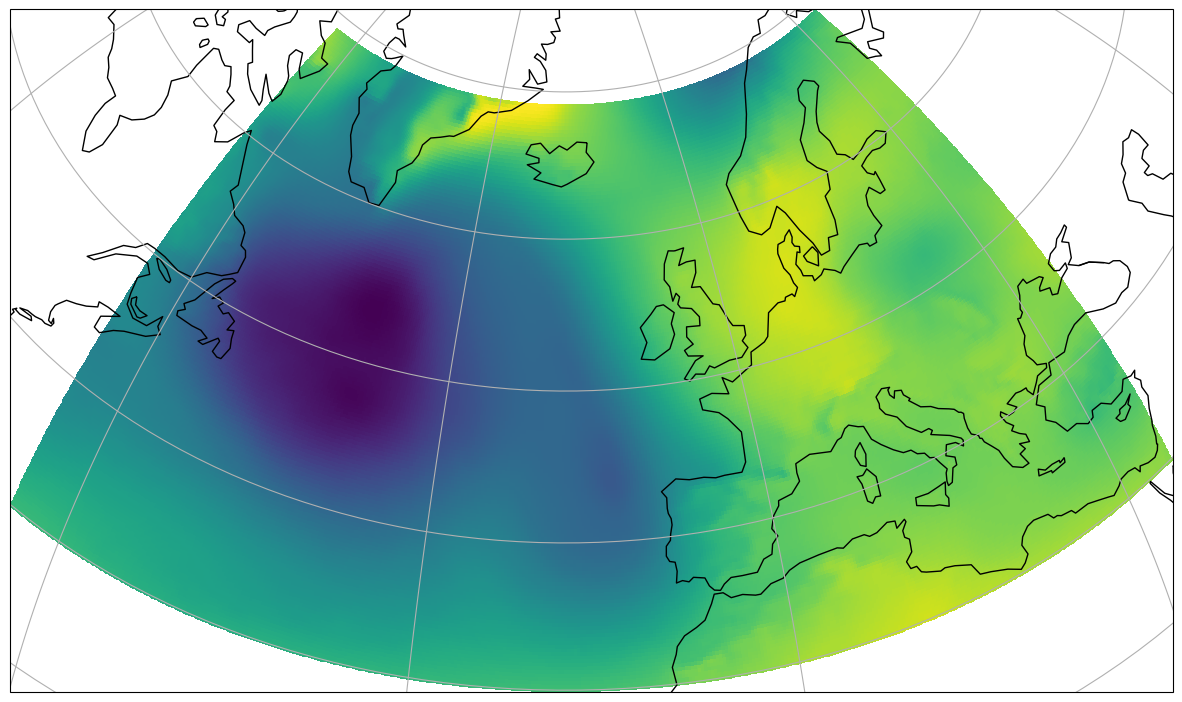

In [9]:
fig, axs = plt.subplots(1, figsize=(15, 10), subplot_kw={'projection': ccrs.Orthographic(-18, 50)})

axs.coastlines()
    # ax.add_feature(cfeature.LAND, edgecolor='black')
axs.gridlines()


axs.pcolormesh(mslp_cropped.longitude, mslp_cropped.latitude, mslp_cropped.msl[0], transform=ccrs.PlateCarree(), cmap='viridis')

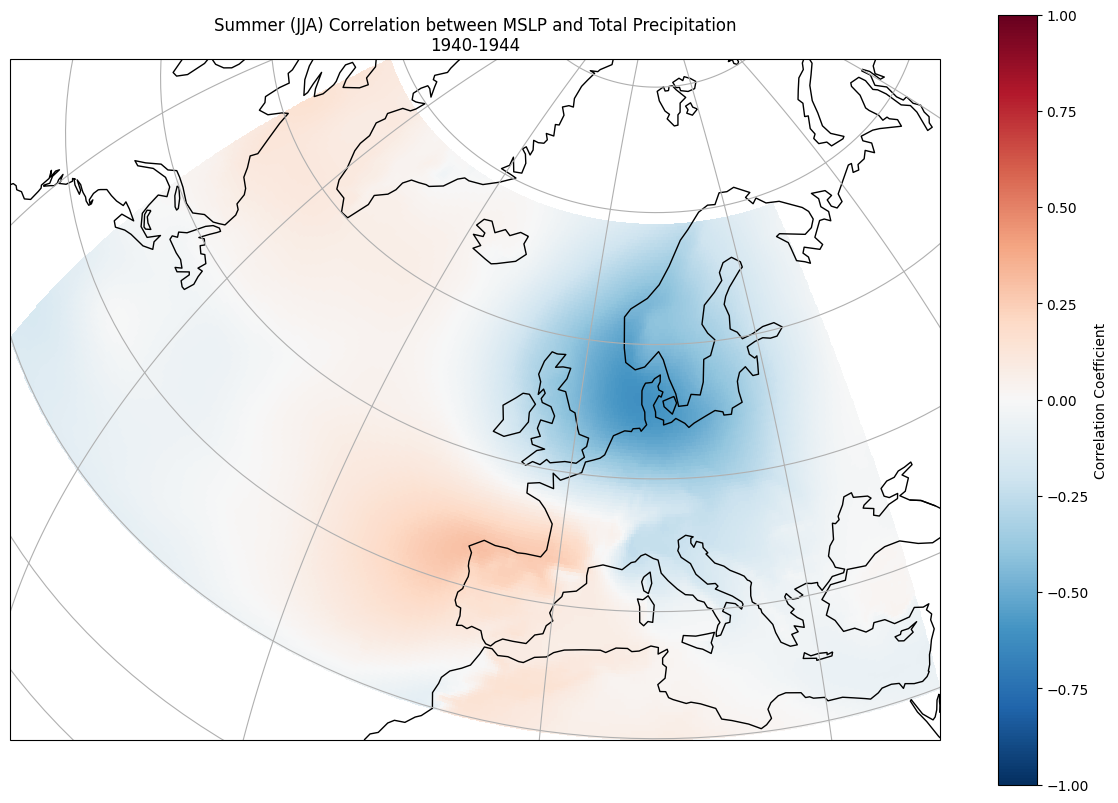

Total number of summer days analyzed: 460
Years included: [1940 1941 1942 1943 1944]


In [10]:
# List of years we want to process
years = range(1940, 1945)  # 1940 to 1945 inclusive

min_lon = -65
max_lon = 35

min_lat = 29
max_lat = 69

# Initialize empty lists to store datasets
mslp_list = []
prec_list = []

# Load and process each year
for year in years:
    # Load the datasets for this year
    mslp_year = xr.open_dataset(f"{main_path}/era5/era5_{year}_mean_sea_level_pressure.nc")
    prec_year = xr.open_dataset(f"{main_path}/era5/era5_{year}_total_precipitation.nc")

    # Crop MSLP to our region of interest (using the same cropping as before)
    mslp_year_cropped = mslp_year.sel(longitude=slice(min_lon,max_lon),
    latitude=slice(max_lat, min_lat))

    # Add month information
    mslp_year_cropped['month'] = mslp_year_cropped.valid_time.dt.month
    prec_year['month'] = prec_year.valid_time.dt.month

    # Calculate total precipitation for each timestep
    total_prec_year = prec_year.tp.sum(dim=['latitude', 'longitude'])

    # Append to our lists
    mslp_list.append(mslp_year_cropped)
    prec_list.append(total_prec_year)

# Combine all years
mslp_all = xr.concat(mslp_list, dim='valid_time')
prec_all = xr.concat(prec_list, dim='valid_time')

# Select summer months
mslp_summer = mslp_all.where(mslp_all.valid_time.dt.month.isin([6, 7, 8]), drop=True)
prec_summer = prec_all.where(prec_all.valid_time.dt.month.isin([6, 7, 8]), drop=True)

# Calculate correlation
corr_map_summer = xr.corr(mslp_summer.msl, prec_summer, dim='valid_time')

# Plot
fig, ax = plt.subplots(1, figsize=(15, 10),
                       subplot_kw={'projection': ccrs.Orthographic(10, 54)})

ax.coastlines()
ax.gridlines()

plot = ax.pcolormesh(corr_map_summer.longitude, corr_map_summer.latitude, corr_map_summer,
                     transform=ccrs.PlateCarree(),
                     cmap='RdBu_r',
                     vmin=-1, vmax=1,
                     shading='auto')

plt.colorbar(plot, ax=ax, label='Correlation Coefficient')
ax.set_title('Summer (JJA) Correlation between MSLP and Total Precipitation\n1940-1944')

plt.show()

# Print information about the combined dataset
print(f"Total number of summer days analyzed: {len(mslp_summer.valid_time)}")
print(f"Years included: {np.unique(mslp_summer.valid_time.dt.year.values)}")

In [11]:
def plot_correlation_map(var1, var2, var1_name, var2_name, years_range, ax, season=None, region=None):
    """
    Calculate and plot correlation maps between two variables on a specified axis.
    
    Parameters:
    -----------
    var1, var2 : str
        Paths to the NetCDF files for the first and second variables
    var1_name, var2_name : str
        Names of the variables in the NetCDF files
    years_range : range
        Range of years to process
    ax : matplotlib axis
        The axis to plot on (must have cartopy projection)
    season : list, optional
        List of months to include (e.g., [6,7,8] for summer)
    region : dict, optional
        Dictionary with keys 'min_lon', 'max_lon', 'min_lat', 'max_lat'
        for cropping the data
    
    Returns:
    --------
    corr_map : xarray.DataArray
        The correlation map data
    plot : matplotlib.collections.QuadMesh
        The plotted pcolormesh object
    """
    # Default region if none specified
    if region is None:
        region = {
            'min_lon': -65,
            'max_lon': 35,
            'min_lat': 29,
            'max_lat': 69
        }
    
    # Initialize empty lists
    var1_list = []
    var2_list = []
    
    # Load and process each year
    for year in years_range:
        # Load datasets
        ds1 = xr.open_dataset(f"{var1.format(year=year)}")
        ds2 = xr.open_dataset(f"{var2.format(year=year)}")
        
        # Crop var1 to region of interest
        ds1_cropped = ds1.sel(
            longitude=slice(region['min_lon'], region['max_lon']),
            latitude=slice(region['max_lat'], region['min_lat'])
        )
        
        # Add month information
        ds1_cropped['month'] = ds1_cropped.valid_time.dt.month
        ds2['month'] = ds2.valid_time.dt.month
        
        # Calculate spatial sum for var2 if it's precipitation
        if 'tp' in var2_name:
            ds2_processed = ds2[var2_name].sum(dim=['latitude', 'longitude'])
        else:
            ds2_processed = ds2[var2_name]
        
        # Append to lists
        var1_list.append(ds1_cropped)
        var2_list.append(ds2_processed)
    
    # Combine all years
    var1_all = xr.concat(var1_list, dim='valid_time')
    var2_all = xr.concat(var2_list, dim='valid_time')
    
    # Select specific season if provided
    if season:
        var1_season = var1_all.where(var1_all.valid_time.dt.month.isin(season), drop=True)
        var2_season = var2_all.where(var2_all.valid_time.dt.month.isin(season), drop=True)
    else:
        var1_season = var1_all
        var2_season = var2_all
    
    # Calculate correlation
     # Calculate correlation
    corr_map = xr.corr(var1_season[var1_name], var2_season, dim='valid_time')

    # Plot on the provided axis
    ax.coastlines()
    ax.gridlines()

    # Get the correct coordinate names
    lon_name = 'longitude' if 'longitude' in corr_map.coords else 'lon'
    lat_name = 'latitude' if 'latitude' in corr_map.coords else 'lat'

    # Print available coordinates for debugging
    print(f"Available coordinates in correlation map: {list(corr_map.coords)}")

    plot = ax.pcolormesh(corr_map[lon_name],
                     corr_map[lat_name],
                     corr_map.squeeze(),  # Remove singleton dimensions
                     transform=ccrs.PlateCarree(),
                     cmap='RdBu_r',
                     vmin=-1, vmax=1,
                     shading='nearest')  # Changed shading mode to 'nearest'


    season_name = {
        (12,1,2): 'Winter (DJF)',
        (3,4,5): 'Spring (MAM)',
        (6,7,8): 'Summer (JJA)',
        (9,10,11): 'Autumn (SON)'
    }.get(tuple(season), 'All seasons') if season else 'All seasons'

    ax.set_title(f'{season_name} Correlation between {var1_name} and {var2_name}\n'
                 f'{min(years_range)}-{max(years_range)}')

    return corr_map, plot

Available coordinates in correlation map: ['number', 'latitude', 'longitude']
Available coordinates in correlation map: ['number', 'pressure_level', 'latitude', 'longitude']
Available coordinates in correlation map: ['number', 'latitude', 'longitude']
Available coordinates in correlation map: ['number', 'pressure_level', 'latitude', 'longitude']


NameError: name 'ax1' is not defined

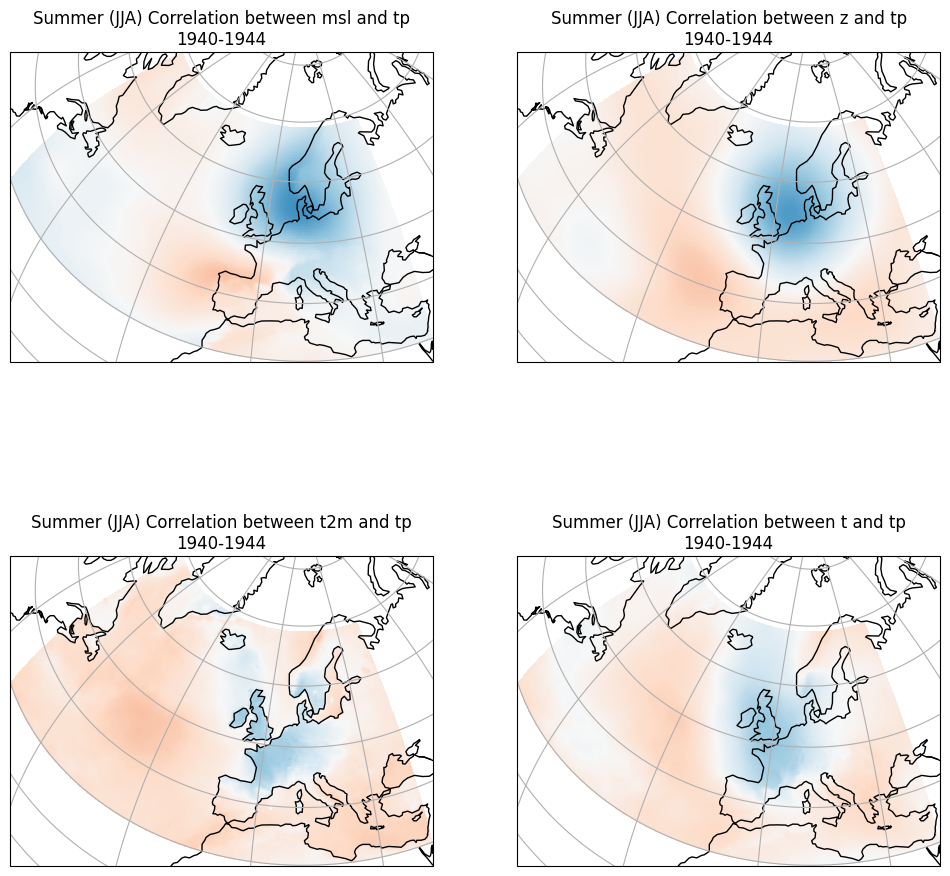

In [16]:
# Create figure with multiple subplots
fig, ax = plt.subplots(2, 2, figsize=(12, 12),
                               subplot_kw={'projection': ccrs.Orthographic(10, 54)})
ax = ax.flatten()
# Define file patterns
main_path = '/Users/lauritsfauli/PycharmProjects/Final_project_APML'
t2m_pattern = f"{main_path}/era5/era5_{{year}}_temperature_2m.nc"
mslp_pattern = f"{main_path}/era5/era5_{{year}}_mean_sea_level_pressure.nc"
geo_pattern = f"{main_path}/era5/era5_{{year}}_geo500hpa.nc"
prec_pattern = f"{main_path}/era5/era5_{{year}}_total_precipitation.nc"
t850_pattern = f"{main_path}/era5/era5_{{year}}_temperature_850hPa.nc"


# Plot summer correlation
corr_map_summer, plot_summer = plot_correlation_map(
    var1=mslp_pattern,
    var2=prec_pattern,
    var1_name='msl',
    var2_name='tp',
    years_range=range(1940, 1945),
    ax=ax[0],
    season=[6, 7, 8]  # Summer
)

# Plot winter correlation
corr_map_geo, plot_geo = plot_correlation_map(
    var1=geo_pattern,
    var2=prec_pattern,
    var1_name='z',
    var2_name='tp',
    years_range=range(1940, 1945),
    ax=ax[1],
    season=[6, 7, 8]  # Winter
)

corr_map_t2m, plot_t2m = plot_correlation_map(
    var1=t2m_pattern,
    var2=prec_pattern,
    var1_name='t2m',
    var2_name='tp',
    years_range=range(1940, 1945),
    ax=ax[2],
    season=[6, 7, 8]  # Winter
)

corr_map_t850, plot_t850 = plot_correlation_map(
    var1=t850_pattern,
    var2=prec_pattern,
    var1_name='t',
    var2_name='tp',
    years_range=range(1940, 1945),
    ax=ax[3],
    season=[6, 7, 8]  # Winter
)




# Add a colorbar that works for both plots
plt.colorbar(plot_summer, ax=[ax1, ax2], label='Correlation Coefficient', orientation='horizontal')

plt.show()

In [120]:
t850

<xarray.Dataset> Size: 508MB
Dimensions:         (valid_time: 366, pressure_level: 1, latitude: 241,
                     longitude: 1440)
Coordinates:
    number          int64 8B ...
  * pressure_level  (pressure_level) float64 8B 850.0
  * latitude        (latitude) float64 2kB 90.0 89.75 89.5 ... 30.5 30.25 30.0
  * longitude       (longitude) float64 12kB -180.0 -179.8 ... 179.5 179.8
  * valid_time      (valid_time) datetime64[ns] 3kB 1940-01-01 ... 1940-12-31
Data variables:
    t               (valid_time, pressure_level, latitude, longitude) float32 508MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-16T12:19 GRIB to CDM+CF via cfgrib-0.9.1...

In [20]:
def plot_correlation_map_lag_days(var1, var2, var1_name, var2_name, years_range, ax, lag_days=0, season=None, region=None):
    """
    Calculate and plot correlation maps between two variables on a specified axis,
    with optional time lag between variables.

    Parameters:
    -----------
    var1, var2 : str
        Paths to the NetCDF files for the first and second variables
    var1_name, var2_name : str
        Names of the variables in the NetCDF files
    years_range : range
        Range of years to process
    ax : matplotlib axis
        The axis to plot on (must have cartopy projection)
    lag_days : int, optional
        Number of days to lag var2 behind var1 (default: 0)
        Positive values mean var2 lags behind var1
    season : list, optional
        List of months to include (e.g., [6,7,8] for summer)
    region : dict, optional
        Dictionary with keys 'min_lon', 'max_lon', 'min_lat', 'max_lat'
        for cropping the data

    Returns:
    --------
    corr_map : xarray.DataArray
        The correlation map data
    plot : matplotlib.collections.QuadMesh
        The plotted pcolormesh object
    """
    # Default region if none specified
    if region is None:
        region = {
            'min_lon': -65,
            'max_lon': 35,
            'min_lat': 29,
            'max_lat': 69
        }

    # Initialize empty lists
    var1_list = []
    var2_list = []

    # Load and process each year
    for year in years_range:
        # Load datasets
        ds1 = xr.open_dataset(f"{var1.format(year=year)}")
        ds2 = xr.open_dataset(f"{var2.format(year=year)}")

        # Crop var1 to region of interest
        ds1_cropped = ds1.sel(
            longitude=slice(region['min_lon'], region['max_lon']),
            latitude=slice(region['max_lat'], region['min_lat'])
        )

        # Add month information
        ds1_cropped['month'] = ds1_cropped.valid_time.dt.month
        ds2['month'] = ds2.valid_time.dt.month

        # Calculate spatial sum for var2 if it's precipitation
        if 'tp' in var2_name:
            ds2_processed = ds2[var2_name].sum(dim=['latitude', 'longitude'])
        else:
            ds2_processed = ds2[var2_name]

        # Append to lists
        var1_list.append(ds1_cropped)
        var2_list.append(ds2_processed)

    # Combine all years
    var1_all = xr.concat(var1_list, dim='valid_time')
    var2_all = xr.concat(var2_list, dim='valid_time')

    # Apply time lag if specified
    if lag_days != 0:
        # Shift var2 by lag_days
        var2_all = var2_all.shift(valid_time=-lag_days)

        # Drop NaN values created by the shift
        valid_times = var2_all.valid_time[~var2_all.isnull()]
        var1_all = var1_all.sel(valid_time=valid_times)
        var2_all = var2_all.sel(valid_time=valid_times)

    # Select specific season if provided
    if season:
        var1_season = var1_all.where(var1_all.valid_time.dt.month.isin(season), drop=True)
        var2_season = var2_all.where(var2_all.valid_time.dt.month.isin(season), drop=True)
    else:
        var1_season = var1_all
        var2_season = var2_all

    # Calculate correlation
    corr_map = xr.corr(var1_season[var1_name], var2_season, dim='valid_time')

    # Plot on the provided axis
    ax.coastlines()
    ax.gridlines()

    # Get the correct coordinate names
    lon_name = 'longitude' if 'longitude' in corr_map.coords else 'lon'
    lat_name = 'latitude' if 'latitude' in corr_map.coords else 'lat'

    plot = ax.pcolormesh(corr_map[lon_name],
                     corr_map[lat_name],
                     corr_map.squeeze(),
                     transform=ccrs.PlateCarree(),
                     cmap='RdBu_r',
                     vmin=-1, vmax=1,
                     shading='nearest')

    season_name = {
        (12,1,2): 'Winter (DJF)',
        (3,4,5): 'Spring (MAM)',
        (6,7,8): 'Summer (JJA)',
        (9,10,11): 'Autumn (SON)'
    }.get(tuple(season), 'All seasons') if season else 'All seasons'

    lag_text = f" (lag: {lag_days} days)" if lag_days != 0 else ""
    ax.set_title(f'{season_name} Correlation between {var1_name} and {var2_name}{lag_text}\n'
                 f'{min(years_range)}-{max(years_range)}')

    return corr_map, plot

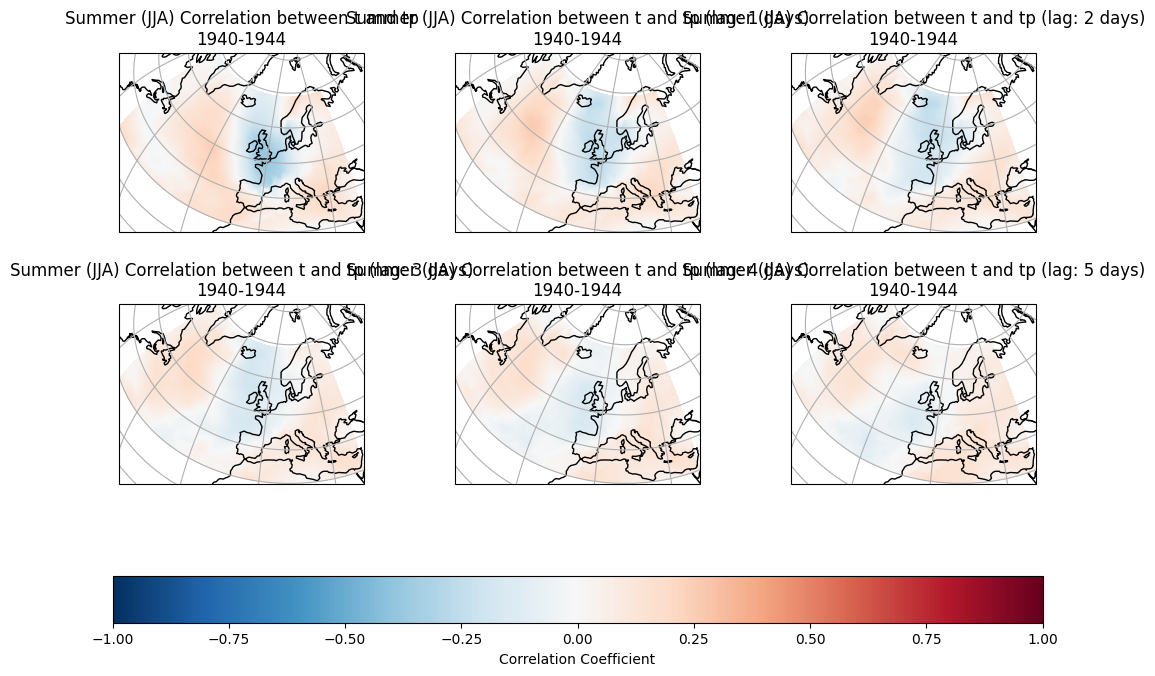

/var/folders/lv/4tgtypmd2kg8ggv7vt0z73280000gn/T/ipykernel_40298/2717142459.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


In [14]:
# Create figure with multiple subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                               subplot_kw={'projection': ccrs.Orthographic(10, 54)})
plt.subplots_adjust(hspace=0.4, wspace=0.3)
axs = axs.flatten()
# Define file patterns
main_path = '/Users/lauritsfauli/PycharmProjects/Final_project_APML'
t2m_pattern = f"{main_path}/era5/era5_{{year}}_temperature_2m.nc"
mslp_pattern = f"{main_path}/era5/era5_{{year}}_mean_sea_level_pressure.nc"
geo_pattern = f"{main_path}/era5/era5_{{year}}_geo500hpa.nc"
prec_pattern = f"{main_path}/era5/era5_{{year}}_total_precipitation.nc"
t850_pattern = f"{main_path}/era5/era5_{{year}}_temperature_850hPa.nc"

for i, ax in enumerate(axs):
    # Plot summer correlation
    corr_map_summer, plot_summer = plot_correlation_map_lag_days(
        var1=t850_pattern,
        var2=prec_pattern,
        lag_days=i,
        var1_name='t',
        var2_name='tp',
        years_range=range(1940, 1945),
        ax=ax,
        season=[6, 7, 8]  # Summer
    )


# Add a colorbar that works for both plots
plt.colorbar(plot_summer, ax=axs, label='Correlation Coefficient', orientation='horizontal')

plt.show()
fig.tight_layout()

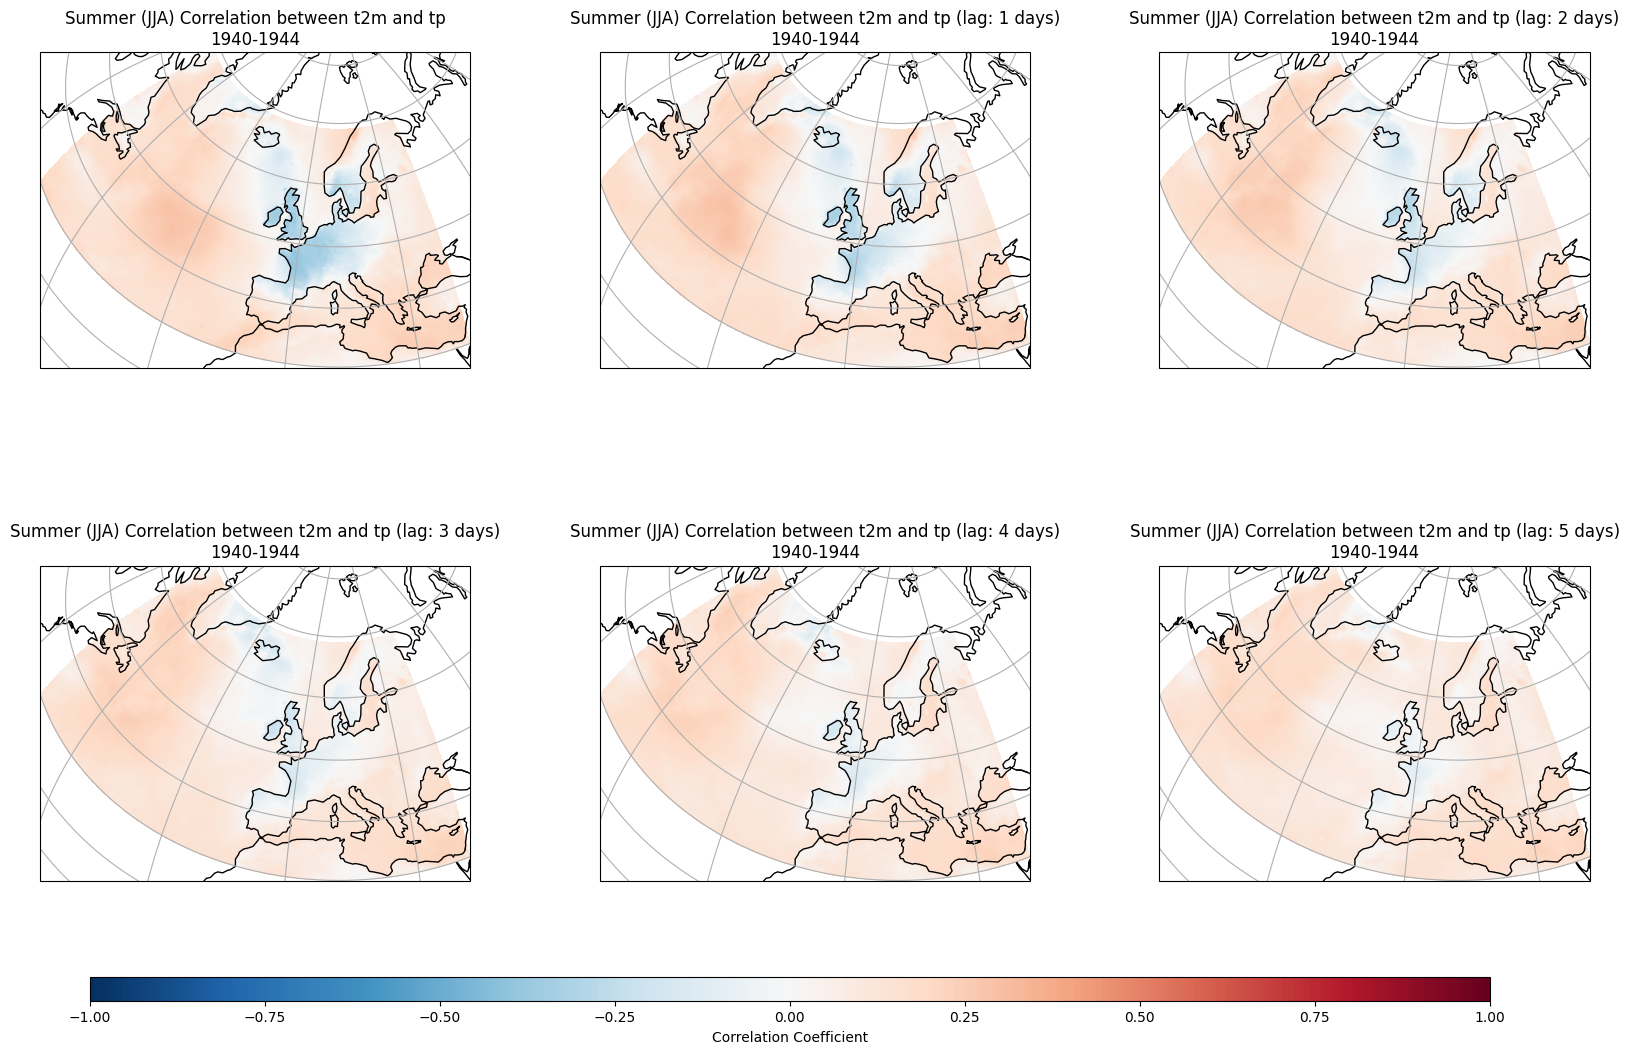

In [19]:
import matplotlib.gridspec as gridspec

# Create figure with multiple subplots
fig = plt.figure(figsize=(20, 12))  # Increased figure size for better readability
gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.25, wspace=0.3)

# Define file patterns
main_path = '/Users/lauritsfauli/PycharmProjects/Final_project_APML'
t2m_pattern = f"{main_path}/era5/era5_{{year}}_temperature_2m.nc"
mslp_pattern = f"{main_path}/era5/era5_{{year}}_mean_sea_level_pressure.nc"
geo_pattern = f"{main_path}/era5/era5_{{year}}_geo500hpa.nc"
prec_pattern = f"{main_path}/era5/era5_{{year}}_total_precipitation.nc"
t850_pattern = f"{main_path}/era5/era5_{{year}}_temperature_850hPa.nc"

# Create subplots
axs = []
for i in range(6):
    ax = fig.add_subplot(gs[i], projection=ccrs.Orthographic(10, 54))
    axs.append(ax)

    # Plot summer correlation
    corr_map_summer, plot_summer = plot_correlation_map_lag_days(
        var1=t2m_pattern,
        var2=prec_pattern,
        var1_name='t2m',
        var2_name='tp',
        lag_days=i,
        years_range=range(1940, 1945),
        ax=ax,
        season=[6, 7, 8]  # Summer
    )

# Add a colorbar at the bottom
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height]
plt.colorbar(plot_summer, cax=cbar_ax, orientation='horizontal', label='Correlation Coefficient')

plt.show()

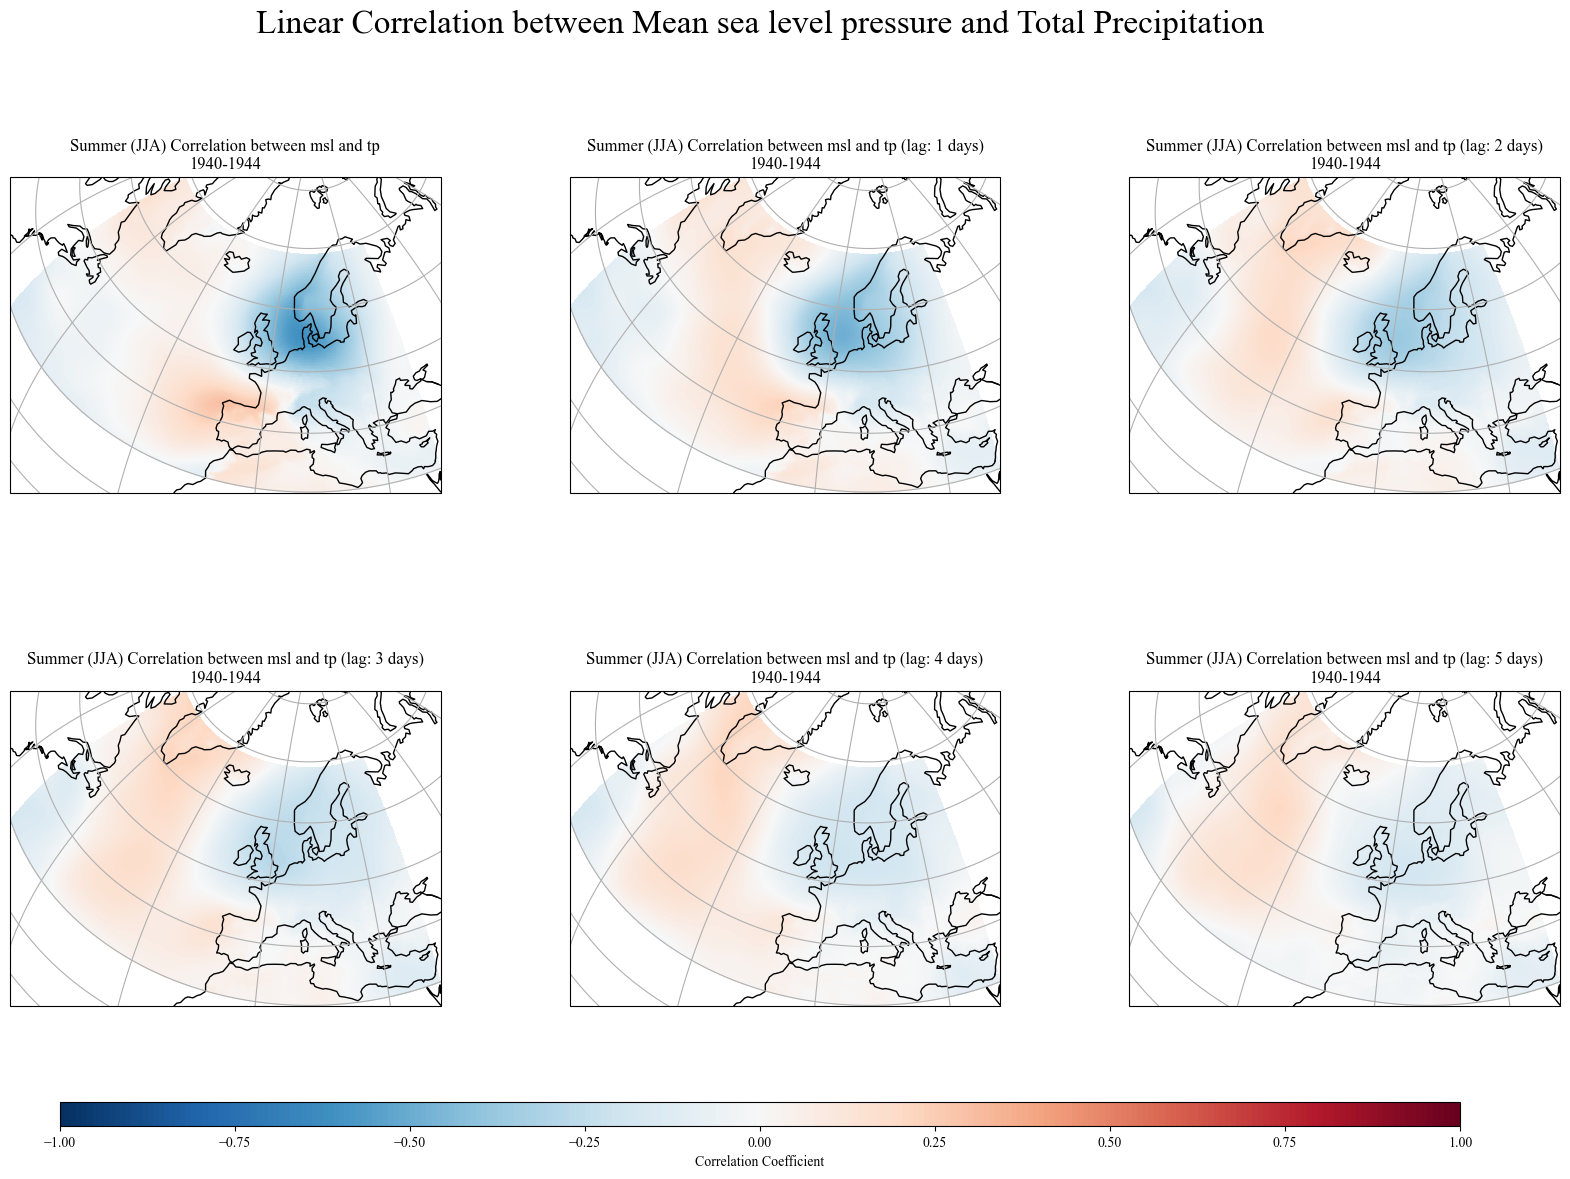

In [26]:
import matplotlib.gridspec as gridspec
def plot_correlation_map_lag_days(var1, var2, var1_name, var2_name, years_range, ax, lag_days=0, season=None, region=None):
    if region is None:
        region = {
            'min_lon': -65,
            'max_lon': 35,
            'min_lat': 29,
            'max_lat': 69
        }

    # Initialize empty lists
    var1_list = []
    var2_list = []

    # Load and process each year
    for year in years_range:
        # Load datasets
        ds1 = xr.open_dataset(f"{var1.format(year=year)}")
        ds2 = xr.open_dataset(f"{var2.format(year=year)}")

        # Crop var1 to region of interest
        ds1_cropped = ds1.sel(
            longitude=slice(region['min_lon'], region['max_lon']),
            latitude=slice(region['max_lat'], region['min_lat'])
        )

        # Add month information
        ds1_cropped['month'] = ds1_cropped.valid_time.dt.month
        ds2['month'] = ds2.valid_time.dt.month

        # Calculate spatial sum for var2 if it's precipitation
        if 'tp' in var2_name:
            ds2_processed = ds2[var2_name].sum(dim=['latitude', 'longitude'])
        else:
            ds2_processed = ds2[var2_name]

        # Append to lists
        var1_list.append(ds1_cropped)
        var2_list.append(ds2_processed)

    # Combine all years
    var1_all = xr.concat(var1_list, dim='valid_time')
    var2_all = xr.concat(var2_list, dim='valid_time')

    # Apply time lag if specified
    if lag_days != 0:
        # Shift var2 by lag_days
        var2_all = var2_all.shift(valid_time=-lag_days)

        # Drop NaN values created by the shift
        valid_times = var2_all.valid_time[~var2_all.isnull()]
        var1_all = var1_all.sel(valid_time=valid_times)
        var2_all = var2_all.sel(valid_time=valid_times)

    # Select specific season if provided
    if season:
        var1_season = var1_all.where(var1_all.valid_time.dt.month.isin(season), drop=True)
        var2_season = var2_all.where(var2_all.valid_time.dt.month.isin(season), drop=True)
    else:
        var1_season = var1_all
        var2_season = var2_all

    # Calculate correlation
    corr_map = xr.corr(var1_season[var1_name], var2_season, dim='valid_time')

    # Plot on the provided axis
    ax.coastlines()
    ax.gridlines()

    # Get the correct coordinate names
    lon_name = 'longitude' if 'longitude' in corr_map.coords else 'lon'
    lat_name = 'latitude' if 'latitude' in corr_map.coords else 'lat'

    plot = ax.pcolormesh(corr_map[lon_name],
                     corr_map[lat_name],
                     corr_map.squeeze(),
                     transform=ccrs.PlateCarree(),
                     cmap='RdBu_r',
                     vmin=-1, vmax=1,
                     shading='nearest')

    season_name = {
        (12,1,2): 'Winter (DJF)',
        (3,4,5): 'Spring (MAM)',
        (6,7,8): 'Summer (JJA)',
        (9,10,11): 'Autumn (SON)'
    }.get(tuple(season), 'All seasons') if season else 'All seasons'

    lag_text = f" (lag: {lag_days} days)" if lag_days != 0 else ""
    ax.set_title(f'{season_name} Correlation between {var1_name} and {var2_name}{lag_text}\n'
                 f'{min(years_range)}-{max(years_range)}')

    return corr_map, plot


# Create figure with multiple subplots
fig = plt.figure(figsize=(20, 12))  # Increased figure size for better readability
gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.25, wspace=0.3)
rc = {
             "font.family": "serif",
             "mathtext.fontset": "stix"
         }
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

# Define file patterns
main_path = '/Users/lauritsfauli/PycharmProjects/Final_project_APML'
t2m_pattern = f"{main_path}/era5/era5_{{year}}_temperature_2m.nc"
mslp_pattern = f"{main_path}/era5/era5_{{year}}_mean_sea_level_pressure.nc"
geo_pattern = f"{main_path}/era5/era5_{{year}}_geo500hpa.nc"
prec_pattern = f"{main_path}/era5/era5_{{year}}_total_precipitation.nc"
t850_pattern = f"{main_path}/era5/era5_{{year}}_temperature_850hPa.nc"

# Create subplots
axs = []
for i in range(6):
    ax = fig.add_subplot(gs[i], projection=ccrs.Orthographic(10, 54))
    axs.append(ax)

    # Plot summer correlation
    corr_map_summer, plot_summer = plot_correlation_map_lag_days(
        var1=mslp_pattern,
        var2=prec_pattern,
        lag_days=i,
        var1_name='msl',
        var2_name='tp',
        years_range=range(1940, 1945),
        ax=ax,
        season=[6, 7, 8]  # Summer
    )

# Add a colorbar at the bottom
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height]
plt.colorbar(plot_summer, cax=cbar_ax, orientation='horizontal', label='Correlation Coefficient')
fig.suptitle('Linear Correlation between Mean sea level pressure and Total Precipitation',fontsize=24)
plt.show()

In [24]:
import matplotlib.gridspec as gridspec

# Create figure with multiple subplots
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 8),
                               subplot_kw={'projection': ccrs.Orthographic(10, 54)})

# Define file patterns
main_path = '/Users/lauritsfauli/PycharmProjects/Final_project_APML'
t2m_pattern = f"{main_path}/era5/era5_{{year}}_temperature_2m.nc"
mslp_pattern = f"{main_path}/era5/era5_{{year}}_mean_sea_level_pressure.nc"
geo_pattern = f"{main_path}/era5/era5_{{year}}_geo500hpa.nc"
prec_pattern = f"{main_path}/era5/era5_{{year}}_total_precipitation.nc"
t850_pattern = f"{main_path}/era5/era5_{{year}}_temperature_850hPa.nc"
    var1=t2m_pattern,
    var2=prec_pattern,
    var1_name='t2m',
    var2_name='tp',

    # Plot summer correlation
corr_map_summer, plot_summer = plot_correlation_map_lag_days(
    var1=t850_pattern,
    var2=prec_pattern,
    lag_days=30,
    var1_name='t',
    var2_name='tp',
    years_range=range(1940, 1945),
    ax=ax,
    season=[6, 7, 8]  # Summer
)

# Add a colorbar at the bottom
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height]
plt.colorbar(plot_summer, cax=cbar_ax, orientation='horizontal', label='Correlation Coefficient')

plt.show()

IndentationError: unexpected indent (207930402.py, line 14)